# Import libraries and data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


!unzip -q "path_images" -d "/content"

In [2]:
!unzip -q "/content/drive/MyDrive/Università/Leonardo/sapienza-training-camp-2022.zip" -d "/content"

In [3]:
!unzip -q "/content/drive/MyDrive/Università/Leonardo/train_classes.zip" -d "/content"

In [4]:
!pip install pytorch_pretrained_vit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11132 sha256=9331159955c36f1dab1d4adffc294f738f51a289a430e393a6eae62ac5d8f2eb
  Stored in directory: /root/.cache/pip/wheels/87/1d/d1/c6852ef6d18565e5aee866432ab40c6ffbd3411d592035cddb
Successfully built pytorch-pretrained-vit


In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns
import tqdm.notebook as tq
from pytorch_pretrained_vit import ViT

dataset_root = "/content"
RANDOM_STATE = 2022
num_classes = 7

In [6]:
df_clean = pd.read_csv("/content/drive/MyDrive/Università/Leonardo/dataset_clean.csv")

In [7]:
# Check if n_row of csv is the same of number_of_train_images
dir_paths = [r'/content/train_classes/battleships',
             r'/content/train_classes/containerships',
             r'/content/train_classes/drilling-rigs',
             r'/content/train_classes/submarines',
             r'/content/train_classes/coast-guard',
             r'/content/train_classes/cruise-ships',
             r'/content/train_classes/motor-yachts']
count = 0
for dir_path in dir_paths:
  count += len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

print(count, df_clean)

1974       Unnamed: 0     file_name  category_name  category_id
0              0  2c24dabe.jpg   motor-yachts            5
1              1  7dcf4553.jpg     submarines            6
2              2  33e34b0c.jpg   motor-yachts            5
3              3  3ac0a11a.jpg   motor-yachts            5
4              4  f6e59377.jpg    coast-guard            1
...          ...           ...            ...          ...
1969        2304  c440313f.jpg   motor-yachts            5
1970        2305  895923e6.jpg   motor-yachts            5
1971        2306  84cb2fed.jpg  drilling-rigs            4
1972        2307  f332a1a2.jpg    battleships            0
1973        2308  843382f5.jpg    coast-guard            1

[1974 rows x 4 columns]


In [8]:
df_clean = df_clean.drop(columns = ['Unnamed: 0'])

In [9]:
df_clean.head()

,file_name,category_name,category_id
0,2c24dabe.jpg,motor-yachts,5
1,7dcf4553.jpg,submarines,6
2,33e34b0c.jpg,motor-yachts,5
3,3ac0a11a.jpg,motor-yachts,5
4,f6e59377.jpg,coast-guard,1


# Train / Test Split + ViT

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
df_train, df_val = train_test_split(df_clean, stratify=df_clean.category_id, test_size=0.33, random_state=RANDOM_STATE)
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)

In [12]:
print(len(df_train), len(df_val))

1322 652


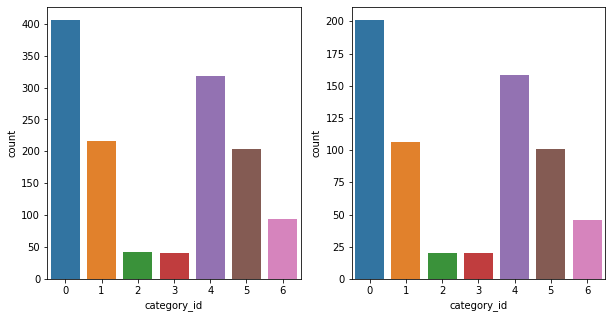

In [13]:
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
sns.countplot(x='category_id' , data=df_train, ax = ax1)
sns.countplot(x='category_id' , data=df_val, ax = ax2)
plt.show()

## Fine - Tuning ViT

In [46]:
# import the model
model = ViT('B_16_imagenet1k', pretrained=True)

Loaded pretrained weights.


Define option for the model

In [47]:
input_size = (384, 384)
cost = torch.nn.CrossEntropyLoss()  # loss function
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(),
                            lr= learning_rate,
                            momentum = 0.9,
                            weight_decay = 1e-4)

In [48]:
import torchvision.transforms as T

batch_size = 8
num_workers = 2 # don't touch

In [49]:
class ShipDataset:
    def __init__(self, root, df, transform):
        self.root = root
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        cat = self.df.category_name[index]
        cat_id = self.df.category_id[index]
        file_name = self.df.file_name[index]
        img_path = os.path.join(self.root, cat, file_name)
  
        with open(img_path, "rb") as fp:
          img = Image.open(fp).convert("RGB")

        # transform it to tensor (or eventually augment it)
        img = self.transform(img)
        return img, cat_id

In [50]:
# set up transforms
train_transforms = T.Compose([T.Resize(input_size),
                              T.RandomHorizontalFlip(),
                              T.ToTensor(), 
                              T.Normalize(mean=(0.5,), std=(0.5,))]
                             )
# Define the ShipDataset, it will return a tuple: (image, label)
train_dataset = ShipDataset("/content/train_classes", df_train, transform=train_transforms)

In [51]:
image_tensor, label_tensor = train_dataset[0]
print("image shape:", image_tensor.shape, "label:", label_tensor)
print("len train_dataset", len(train_dataset))

image shape: torch.Size([3, 384, 384]) label: 0
len train_dataset 1322


In [52]:
val_transform = T.Compose([ T.Resize(input_size),
                            T.RandomHorizontalFlip(),
                            T.ToTensor(), 
                            T.Normalize(mean=(0.5,), std=(0.5,))]
                            )
# Take care ! you have to pass df_val and val_transform
val_dataset = ShipDataset("/content/train_classes", df_val, transform=val_transform)
print("len val_dataset", len(val_dataset))

len val_dataset 652


In [53]:
# The dataloader is an efficient loader that load the examples for you, forming the batches
train_loader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=True,    # You are in trainin mode, you should shuffle!
                            drop_last=True   # with this command you will have always a constant number of batch elements
                            )

val_loader = torch.utils.data.DataLoader(val_dataset,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False   # You are in validation mode, you don't need to shuffle!
                            )

### Training the model

In [85]:
from sklearn.metrics import f1_score

# WE want exploit the GPU!
device = "cuda"
epochs = 25 # the number of epochs 

In [86]:
def train():
    # send model to the GPU!
    model.to(device)
    n = len(train_loader)
    for epoch in range(epochs):
        # Train mode
        model.train()
        for iter, (image_batch, label_batch) in enumerate(tq.tqdm(train_loader)):
            # Stop to accumulate gradients
            optimizer.zero_grad()

            # send tensors to the GPU!
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
            # compute the logits and squeeze the last dimension
            logits = model(image_batch).squeeze()
            # Compute the mini-batch cost
            cost_tensor = cost(logits, label_batch)
            # sometimes print the loss
            if iter % int(0.25*n) == 0:
                print(f"Epoch {epoch}, iter {iter}/{n} Train cost {cost_tensor.item():.6f}")
            # Gradient computation!
            cost_tensor.backward()
            # Optimizer step!
            optimizer.step()
        # Eval the model after every epoch
        meanf1score,meanf1scoreMicro, y_true, y_pred = eval(model, val_loader)
        print(f"Val meanF1score macro: {meanf1score*100:.4f}")
        print(f"Val meanF1score micro: {meanf1scoreMicro*100:.4f}")


def eval(model, loader):
    y_pred = []
    y_true = []
    # eval mode
    model.eval()
    for images, labels in loader:
        images = images.to(device)
        with torch.no_grad():
            logits = model(images)
        y_pred += list(torch.argmax(logits,1).cpu().numpy())
        y_true += list(labels.cpu().numpy())

    meanf1score = f1_score(y_true, y_pred, average="macro")
    meanf1scoreMicro = f1_score(y_true, y_pred, average="micro")

    return meanf1score, meanf1scoreMicro,  y_true, y_pred

In [87]:
# Train!
train()

  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 0, iter 0/165 Train cost 0.000452
Epoch 0, iter 41/165 Train cost 0.000197
Epoch 0, iter 82/165 Train cost 0.000132
Epoch 0, iter 123/165 Train cost 0.001195
Epoch 0, iter 164/165 Train cost 0.001146
Val meanF1score macro: 97.5158
Val meanF1score micro: 98.0061


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 1, iter 0/165 Train cost 0.000147
Epoch 1, iter 41/165 Train cost 0.000092
Epoch 1, iter 82/165 Train cost 0.000116
Epoch 1, iter 123/165 Train cost 0.000258
Epoch 1, iter 164/165 Train cost 0.000163
Val meanF1score macro: 97.6215
Val meanF1score micro: 98.1595


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 2, iter 0/165 Train cost 0.000521
Epoch 2, iter 41/165 Train cost 0.000453
Epoch 2, iter 82/165 Train cost 0.000332
Epoch 2, iter 123/165 Train cost 0.000422
Epoch 2, iter 164/165 Train cost 0.000118
Val meanF1score macro: 97.6215
Val meanF1score micro: 98.1595


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 3, iter 0/165 Train cost 0.000566
Epoch 3, iter 41/165 Train cost 0.000316
Epoch 3, iter 82/165 Train cost 0.000116
Epoch 3, iter 123/165 Train cost 0.000799
Epoch 3, iter 164/165 Train cost 0.000165
Val meanF1score macro: 97.7267
Val meanF1score micro: 98.3129


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 4, iter 0/165 Train cost 0.000432
Epoch 4, iter 41/165 Train cost 0.000723
Epoch 4, iter 82/165 Train cost 0.000158
Epoch 4, iter 123/165 Train cost 0.000118
Epoch 4, iter 164/165 Train cost 0.000597
Val meanF1score macro: 97.6215
Val meanF1score micro: 98.1595


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 5, iter 0/165 Train cost 0.000142
Epoch 5, iter 41/165 Train cost 0.000301
Epoch 5, iter 82/165 Train cost 0.000388
Epoch 5, iter 123/165 Train cost 0.000075
Epoch 5, iter 164/165 Train cost 0.000497
Val meanF1score macro: 97.7621
Val meanF1score micro: 98.3129


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 6, iter 0/165 Train cost 0.000139
Epoch 6, iter 41/165 Train cost 0.000163
Epoch 6, iter 82/165 Train cost 0.000198
Epoch 6, iter 123/165 Train cost 0.000407
Epoch 6, iter 164/165 Train cost 0.001105
Val meanF1score macro: 97.5158
Val meanF1score micro: 98.0061


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 7, iter 0/165 Train cost 0.000210
Epoch 7, iter 41/165 Train cost 0.000156
Epoch 7, iter 82/165 Train cost 0.000189
Epoch 7, iter 123/165 Train cost 0.000151
Epoch 7, iter 164/165 Train cost 0.000171
Val meanF1score macro: 97.6215
Val meanF1score micro: 98.1595


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 8, iter 0/165 Train cost 0.000136
Epoch 8, iter 41/165 Train cost 0.000155
Epoch 8, iter 82/165 Train cost 0.000217
Epoch 8, iter 123/165 Train cost 0.000106
Epoch 8, iter 164/165 Train cost 0.000327
Val meanF1score macro: 97.4810
Val meanF1score micro: 98.0061


  0%|          | 0/165 [00:00<?, ?it/s]

Epoch 9, iter 0/165 Train cost 0.000274
Epoch 9, iter 41/165 Train cost 0.000566
Epoch 9, iter 82/165 Train cost 0.000177
Epoch 9, iter 123/165 Train cost 0.000240
Epoch 9, iter 164/165 Train cost 0.000063
Val meanF1score macro: 97.6215
Val meanF1score micro: 98.1595


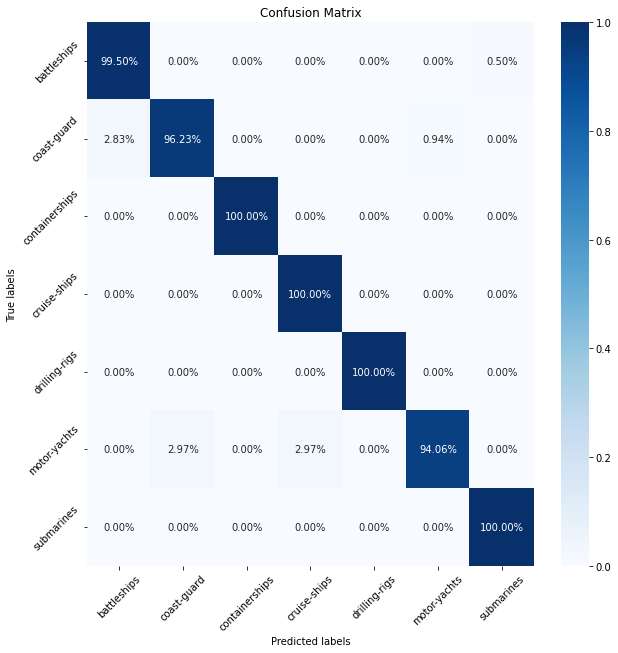

In [74]:
from sklearn.metrics import confusion_matrix

category_names = sorted(list(df_train.category_name.unique()))

metric_dict, metric_dict2, y_true, y_pred = eval(model, val_loader)
cf_matrix = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix / cf_matrix.sum(axis=1).reshape(-1,1), annot=True, fmt='.2%', cmap='Blues', ax=ax)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(category_names, rotation = 45)
ax.yaxis.set_ticklabels(category_names, rotation = 45);

In [89]:
# Save model
torch.save(model, "/content/drive/MyDrive/Università/Leonardo/modelVision2")
# Load model
#model = torch.load("/content/drive/MyDrive/Leonardo/modelVision")

# Test prediction and Submit

In [90]:
%cd /content

/content


In [91]:
# Define the test dataset
from torchvision.datasets import ImageFolder

In [92]:
%ls | wc -l

9


In [93]:
test_dataset = ImageFolder("/content/test", transform=val_transform)

In [94]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 2952
    Root location: /content/test
    StandardTransform
Transform: Compose(
               Resize(size=(384, 384), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [95]:
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size,
                                          num_workers=num_workers,
                                          shuffle=False)

In [96]:
y_pred = []
# eval mode
model.eval()
for images, labels in test_loader:
    images = images.to(device)
    with torch.no_grad():
        logits = model(images)
    y_pred += list(torch.argmax(logits,1).cpu().numpy())


In [97]:
df_submission = pd.DataFrame()
df_submission["file_name"] = [os.path.basename(p[0]) for p in test_dataset.samples]
df_submission["category_id"] = y_pred
df_submission.to_csv("visual_transformer2.csv", index=False)

In [98]:
len(df_submission)

2952

## Cheaking the results

Histogram of the class labels

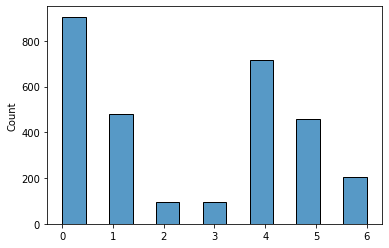

In [69]:
import seaborn as sns
sns.histplot(np.array(df_submission.category_id))

See how different is with the last similar submission

Inspect some test label

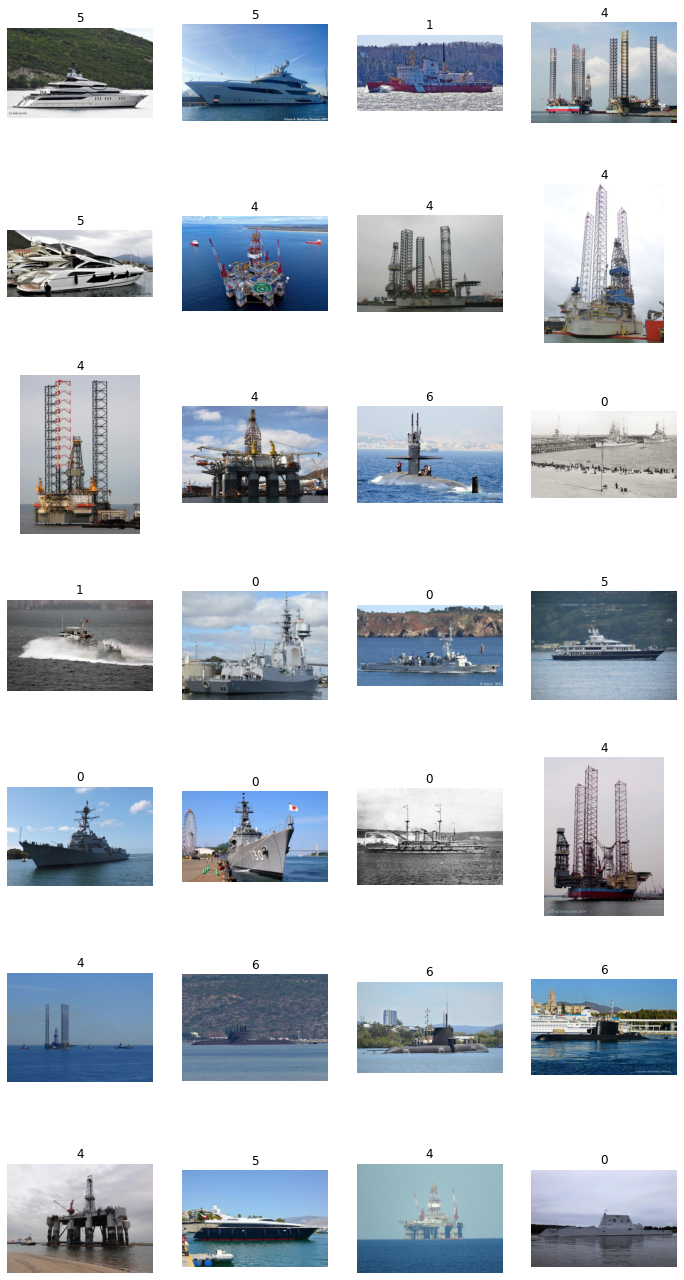

In [70]:
# visualize the top 28 train images
plt.figure(figsize=(12,24))

for i in range(1,29):
    plt.subplot(7,4,i)
    plt.title(f'{df_submission["category_id"].values[i]}')
    plt.imshow(np.array(Image.open('/content/test/test/'+df_submission['file_name'].values[i])))
    plt.axis('off')
plt.show()
